In [1]:
import candas as can
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

from candas.test import QuantStudio
from candas.learn import ParameterSet
from candas.lims import Librarian, library

base_pth, code_pth, data_pth, _, fig_pth = can.utils.setup_paths(make_missing=False)
plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
width = 3.65
height = 0.829
figsize = (width, height)
ticklabelsize = 6
labelsize = 6
spotsize = 6**2
xticks = [2,4,6,8]

mar_l = 0.275
mar_r = 0.04
mar_t = 0.04
mar_b = 0.27

In [3]:
def format_sns_axes(g):
    fig = g.figure
    fig.set_size_inches(figsize)

    plt.setp(
        g.axes,
        ylim=[-1.1, 1.1],
        xticks=xticks,
        xlim=[1, 9],
        xlabel="",
        xticklabels="",
        title="",
    )
    for i, ax in enumerate(g.axes.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1.5, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        if i > 0:
            ax.yaxis.set_tick_params(length=0)
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
    )

In [4]:
print(0.075*width)
print(0.325*height)
print((1-0.99)*width)
print((1-0.95)*height)

0.27375
0.26942499999999997
0.03650000000000003
0.041450000000000035


In [5]:
cmax=40

JG063A = QuantStudio(data_pth / 'JG063A Competitor Concentration Sweep.xlsx', 'JG063A')
JG063B = QuantStudio(data_pth / 'JG063B Competitor Concentration sweep 2.xlsx', 'JG063B')
JG063I = QuantStudio(data_pth / 'JG063I Primer Probe Sweep 5 logs.xlsx', 'JG063I')
JG034 = QuantStudio(data_pth / 'JG034 TMCC1 Gen2 Competitors - 59C v3.xlsx', 'JG034')

for qs in [JG063A, JG063B, JG063I, JG034]:
    print(f'Processing {qs.experiment}')
    (qs
        .import_data()
        .format_reactions()
        .index_reactions()
        .subtract_background()
    )
    
    qs.reactions.data.drop(qs.reactions.data.index[qs.reactions.data.Well==281], inplace=True)
    
    (qs
        .normalize_reactions(cmax=cmax, method='max')
        .invert_fluorophore('HEX')
    )
    
    if qs.experiment=='JG063I':
        primerprobe = (qs.reactions.data.Sample
               .str.split(' ', expand=True)[0]
               .str.split('+', expand=True)
               .rename(columns={0:'Primer nM', 1:'Probe nM'})
              )

        qs.reactions.data = qs.reactions.data.merge(primerprobe, left_index=True, right_index=True)
    elif qs.experiment=='JG034':
        qs.reactions.data.Target = qs.reactions.data.Target.str.split(' - ').map(lambda row: row[0])

    # Denote competitor and WT concentration in each well
    syn_copies = qs.reactions.wide.query('Reporter=="HEX"')[['Well','lg10_Copies']].rename(columns={'lg10_Copies': 'SYN_Copies'})
    wt_copies = qs.reactions.wide.query('Reporter=="FAM"')[['Well','lg10_Copies']].rename(columns={'lg10_Copies': 'WT_Copies'})
    qs.reactions.data = (
        qs.reactions.data
        .merge(syn_copies, on='Well')
        .merge(wt_copies, on='Well')
    )
    
    if qs.experiment in ['JG063A', 'JG063B']:
        qs.reactions.data = qs.reactions.data.assign(Target = qs.reactions.data.Sample)

    qs.reactions.neaten()
    qs.extract_endpoints(cmax=cmax, name='FAM-HEX', method='diff')

Processing JG063A
Processing JG063B
Processing JG063I
Processing JG034


In [6]:
hue = 'FAM-HEX'
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)

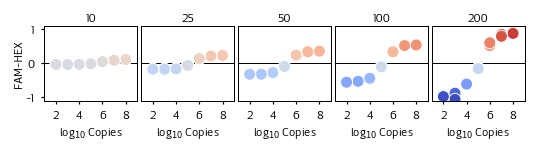

In [29]:
this = JG063I.endpoints[
    (JG063I.endpoints['Probe nM'] == '200') &
    (JG063I.endpoints['WT_Copies'] > 1)
]

g = sns.relplot(data = this,
                x='WT_Copies', y='FAM-HEX', col = 'Primer nM', units='Reaction', hue = 'FAM-HEX',
                legend = False, palette = 'coolwarm', hue_norm = norm, kind='scatter', estimator=None,
                s=spotsize,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

format_sns_axes(g)

for nM, ax in g.axes_dict.items():
    ax.set_xticklabels(xticks)
    ax.set_xlabel('log$_{10}$ Copies', fontsize=labelsize, labelpad=2)
    ax.set_title(f'{int(nM)}', fontsize=labelsize, pad=2)
    
plt.savefig(fig_pth / 'JG063 primer conc.png', dpi=600, transparent=True);
plt.savefig(fig_pth / 'JG063 primer conc.svg', dpi=600, transparent=True);

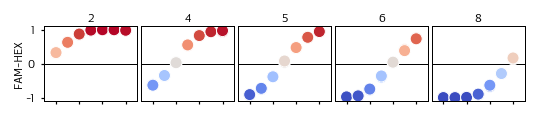

In [32]:
from copy import copy

JG063A_lim = copy(JG063A)

JG063A_lim.reactions.data = JG063A_lim.reactions.data[JG063A_lim.reactions.data['Sample'] == "S056.4.2_vs_S056.4.12"]

(JG063A_lim
    .invert_fluorophore('HEX')
    .normalize_reactions(cmax=cmax, method='min-max')
    .invert_fluorophore('HEX')
    .extract_endpoints(cmax=cmax, name='FAM-HEX', method='bipolar')
    )

this = JG063A_lim.endpoints[
    (JG063A_lim.endpoints['Sample'] == "S056.4.2_vs_S056.4.12") &
    (JG063A_lim.endpoints['WT_Copies'] > 1)
]

g = sns.relplot(data = this,
                x='lg10_Copies', y='FAM-HEX', col = 'SYN_Copies', units='Reaction', hue = 'FAM-HEX',
                legend = False, palette = 'coolwarm', hue_norm = norm, 
                kind='scatter', estimator=None, s=spotsize,
                facet_kws={
                    'margin_titles': False,
                    'despine': False})

format_sns_axes(g)

for cps, ax in g.axes_dict.items():
    ax.set_title(f'{int(cps)}', fontsize=labelsize, pad=2)

plt.savefig(fig_pth / 'JG063 SYN conc.png', dpi=600, transparent=True);
plt.savefig(fig_pth / 'JG063 SYN conc.svg', dpi=600, transparent=True);

In [24]:
lib = Librarian().load(library).open()

targets = ['S056.4.3', 'S056.4.1', 'GC55', 'S056.4.4', 'GC15']
target_codes = ['S056.4.3', 'S056.4.1', 'S044.14', 'S056.4.4', 'S044.9']

bp_gc = lib.bp_gc_by('Fragment').set_index('Name')

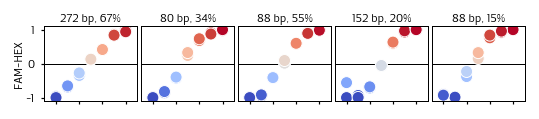

In [27]:

endpoints = pd.concat([
    (JG063A.endpoints[((JG063A.endpoints.SYN_Copies==5) & (JG063A.endpoints.Sample=='S056.4.2_vs_S056.4.12')) |
                      ((JG063A.endpoints.SYN_Copies==5) & (JG063A.endpoints.Sample=='S056.4.4_vs_S056.4.12'))]
     .assign(Target = lambda df: df.Target.str.split('_').str[0])
     ),
    (JG063B.endpoints[((JG063B.endpoints.SYN_Copies==4) & (JG063B.endpoints.Sample=='S056.4.1_vs_S056.4.12')) | 
                      ((JG063B.endpoints.SYN_Copies==6) & (JG063B.endpoints.Sample=='S056.4.3_vs_S056.4.12'))]
     .assign(Target = lambda df: df.Target.str.split('_').str[0])
     ), 
    JG034.endpoints
])

endpoints = endpoints[
    endpoints['Target'].isin(targets) &
    (endpoints['WT_Copies'] > 1)
]

for target in targets:
    this_data = endpoints['Target'] == target
    mn = endpoints.loc[this_data, 'FAM-HEX'].min()
    mx = endpoints.loc[this_data, 'FAM-HEX'].max()
    endpoints.loc[this_data, 'FAM-HEX'] = (endpoints.loc[this_data, 'FAM-HEX'] - mn) / (mx - mn) *2 - 1


g = sns.relplot(data = endpoints,
                x='WT_Copies', y='FAM-HEX', col = 'Target', col_order=targets,
                units='Reaction', hue = 'FAM-HEX', palette = 'coolwarm',
                legend = False, kind='scatter', estimator=None, s=spotsize,
                facet_kws={
                    'margin_titles': False,
                    'despine': False})
    
format_sns_axes(g)

for code, (target, ax) in zip(target_codes, g.axes_dict.items()):
    bp, gc = bp_gc.loc[code][['BP','GC']]
    title = f'{int(bp)} bp, {int(np.round(gc*100))}%'
    ax.set_title(title, fontsize=labelsize, pad=2)

plt.savefig(fig_pth / 'JG063 seq design.png', dpi=600, transparent=True);
plt.savefig(fig_pth / 'JG063 seq design.svg', dpi=600, transparent=True);